In [1]:
import urllib.request
import zipfile

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
filename = "jena_climate_2009_2016.csv.zip"
urllib.request.urlretrieve(url, filename)
with zipfile.ZipFile("jena_climate_2009_2016.csv.zip","r") as zip_ref:
    zip_ref.extractall()

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
   data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

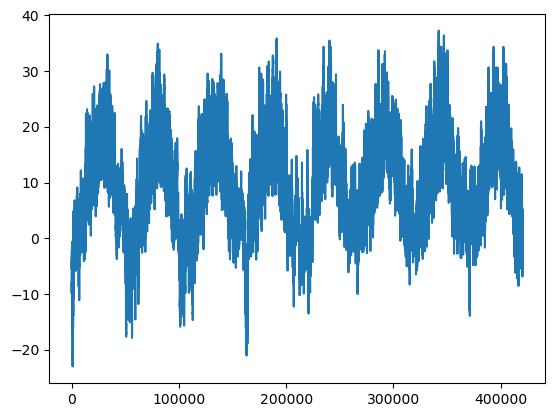

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

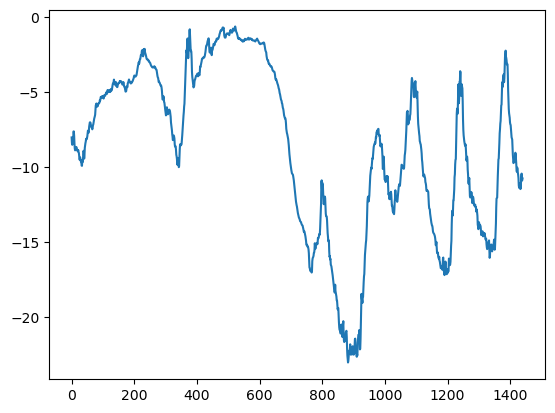

In [5]:
plt.plot(range(1440), temperature[:1440]) 

In [6]:
from tensorflow import keras
import numpy as np

total = len(temperature)
train = total // 2
val = (total - train) // 2
test = total - train - val

delay = 1 # pasos de tiempo para retroceder (predecir temperatura de mañana con datos de hoy)
sequence_length = 120 
sampling_rate = 1 # cada cuanto vas a tomar datos (en este caso cada muestra, o sea cada 10 min)
batch_size = 10

print("Totales =", total)
print("Entrenamiento =", train)
print("Validacion =", val)
print("Prueba =", test)

Totales = 420451
Entrenamiento = 210225
Validacion = 105113
Prueba = 105113


In [7]:
# Conjuntos de secuencias
# entrenamiento
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train)
# validacion
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train,
    end_index=train + val)
# test
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=val+train,
    end_index=None)

# Conv 1D

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Lambda, Convolution1D
from tensorflow.keras.utils import to_categorical

In [9]:
def slice(x, slice_length):
         return x[:, -slice_length:, :]

ks = 5
look_ahead =  delay

modeldil = Sequential()

modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1,
                           batch_input_shape=(None, None, 1)))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))

modeldil.add(Dense(1))
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))

modeldil.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          5152      
                                                                 
 dense (Dense)               (None, None, 1)           33        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 15681 (61.25 KB)
Trainable params: 15681 (

In [10]:
modeldil.compile(optimizer='adam',loss='mean_squared_error')

histdil = modeldil.fit(train_dataset,
                    epochs=20,#tenia 200
                    batch_size=batch_size,
                    validation_data=val_dataset, verbose=0)

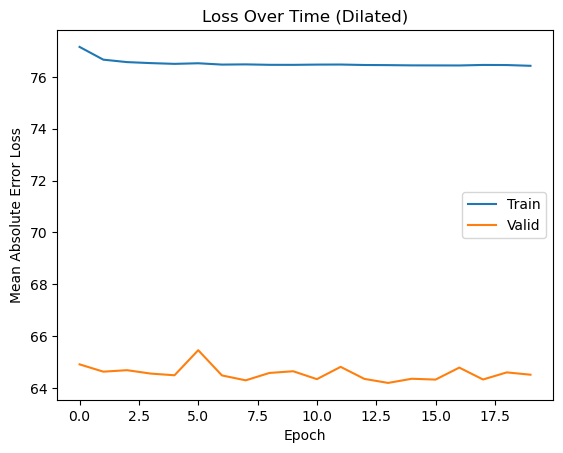

In [11]:
plt.plot(histdil.history['loss'])
plt.plot(histdil.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time (Dilated)')
plt.legend(['Train','Valid'])

10500/10500 [==============================] - 36s 3ms/step


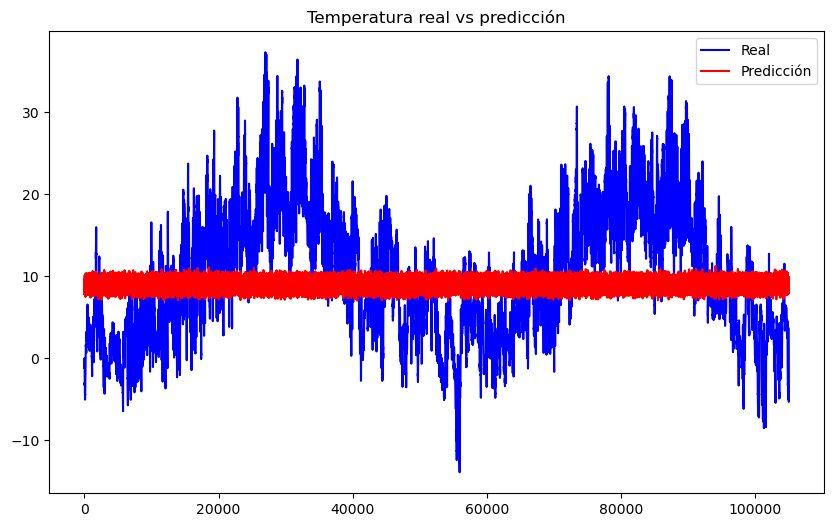

In [12]:
predictions = modeldil.predict(test_dataset)
predictions = predictions.flatten()
real_data = temperature[val+train:]
real_data = real_data[:len(predictions)]

plt.figure(figsize=(10,6))
plt.plot(real_data, color='blue', label='Real')
plt.plot(predictions, color='red', label='Predicción')
plt.title('Temperatura real vs predicción')
plt.legend()
plt.show()

### Intento 2

In [13]:
delay = 10 # pasos de tiempo para retroceder (predecir temperatura de mañana con datos de hoy)
sequence_length = 10 
sampling_rate = 1 # cada cuanto vas a tomar datos (en este caso cada muestra, o sea cada 10 min)
batch_size = 100

In [14]:
# Conjuntos de secuencias
# entrenamiento
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=train)
# validacion
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=train,
    end_index=train + val)
# test
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=val+train,
    end_index=None)

In [15]:
def slice(x, slice_length):
         return x[:, -slice_length:, :]

ks = 5
look_ahead =  delay

modeldil = Sequential()

modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1,
                           batch_input_shape=(None, None, 1)))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))

modeldil.add(Dense(1))
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))

modeldil.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 32)          192       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_7 (Conv1D)           (None, None, 32)          5152      
                                                                 
 dense_1 (Dense)             (None, None, 1)           33        
                                                                 
 lambda_1 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 15681 (61.25 KB)
Trainable params: 15681

In [16]:
import winsound
modeldil.compile(optimizer='adam',loss='mean_squared_error')

histdil = modeldil.fit(train_dataset,
                    epochs=100,#tenia 200
                    batch_size=batch_size,
                    validation_data=val_dataset, verbose=0)

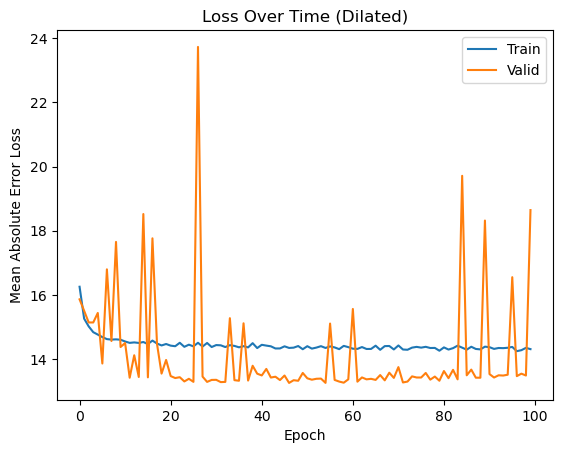

In [19]:
plt.plot(histdil.history['loss'])
plt.plot(histdil.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time (Dilated)')
plt.legend(['Train','Valid'])

1051/1051 [==============================] - 6s 5ms/step


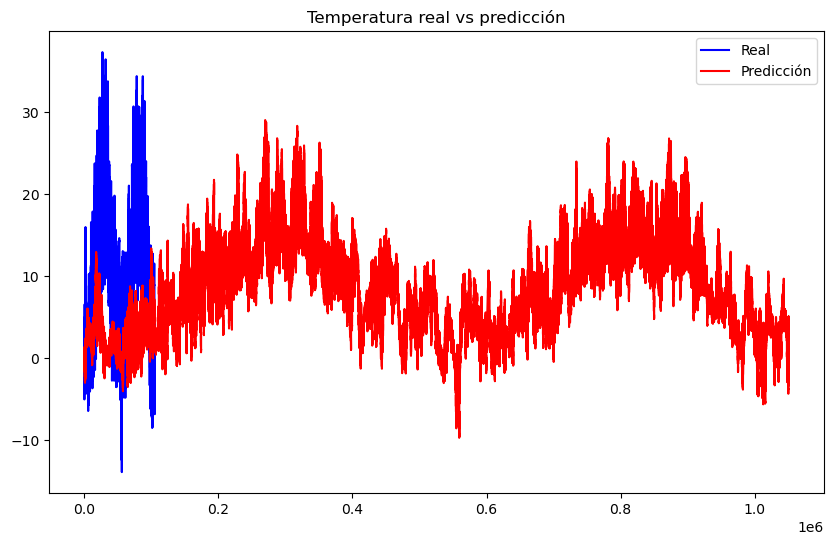

In [20]:
predictions = modeldil.predict(test_dataset)
predictions = predictions.flatten()
real_data = temperature[val+train:]
real_data = real_data[:len(predictions)]

plt.figure(figsize=(10,6))
plt.plot(real_data, color='blue', label='Real')
plt.plot(predictions, color='red', label='Predicción')
plt.title('Temperatura real vs predicción')
plt.legend()
plt.show()

In [30]:
true_values = []
for item in test_dataset:
    true_values.extend(item[1].numpy())

# Crear una lista de índices para el eje x
indices = list(range(len(true_values)))


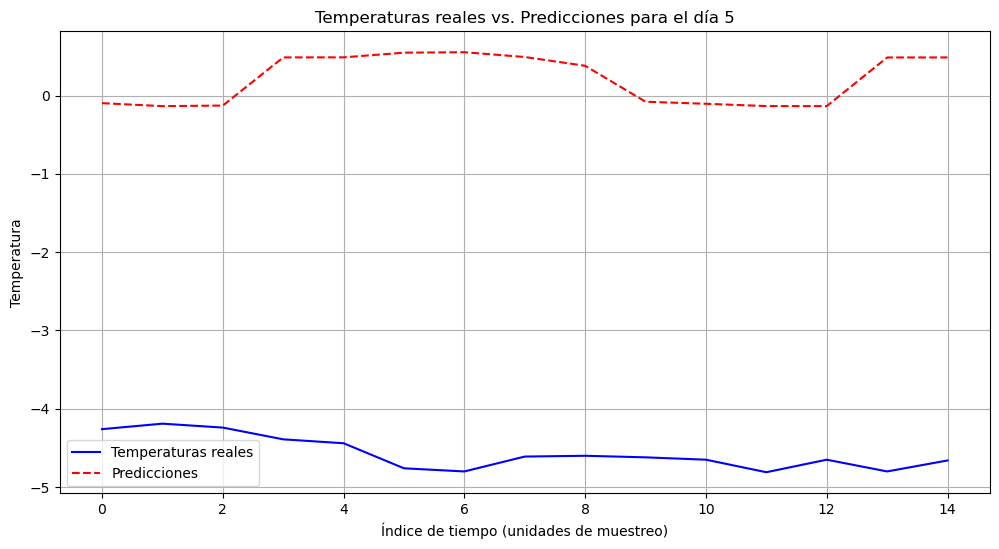

In [35]:
# Definir el día que deseas visualizar (por ejemplo, el día 100)
day_to_visualize = 5

# Obtener las temperaturas reales y las predicciones para ese día
true_values_day = true_values[day_to_visualize * sequence_length: (day_to_visualize + 1) * sequence_length]
predictions_day = predictions[day_to_visualize * sequence_length: (day_to_visualize + 1) * sequence_length]

# Crear una lista de índices para el eje x (correspondiente a ese día)
indices_day = list(range(len(true_values_day)))
plt.figure(figsize=(12, 6))
plt.plot(indices_day, true_values_day, label='Temperaturas reales', color='blue')
plt.plot(indices_day, predictions_day, label='Predicciones', color='red', linestyle='--')
plt.xlabel('Índice de tiempo (unidades de muestreo)')
plt.ylabel('Temperatura')
plt.legend()
plt.title(f'Temperaturas reales vs. Predicciones para el día {day_to_visualize}')
plt.grid(True)
plt.show()


### Tercer Intento

In [37]:
delay = 10 # pasos de tiempo para retroceder (predecir temperatura de mañana con datos de hoy)
sequence_length = 15 
sampling_rate = 1 # cada cuanto vas a tomar datos (en este caso cada muestra, o sea cada 10 min)
batch_size = 168
# Conjuntos de secuencias
# entrenamiento
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=train)
# validacion
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=train,
    end_index=train + val)
# test
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=val+train,
    end_index=None)

In [38]:
def slice(x, slice_length):
         return x[:, -slice_length:, :]

ks = 3
look_ahead =  delay

modeldil = Sequential()

modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1,
                           batch_input_shape=(None, None, 1)))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))

modeldil.add(Dense(1))
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))

modeldil.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, None, 32)          128       
                                                                 
 conv1d_13 (Conv1D)          (None, None, 32)          3104      
                                                                 
 conv1d_14 (Conv1D)          (None, None, 32)          3104      
                                                                 
 conv1d_15 (Conv1D)          (None, None, 32)          3104      
                                                                 
 dense_3 (Dense)             (None, None, 1)           33        
                                                                 
 lambda_3 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 9473 (37.00 KB)
Trainable params: 9473 (

In [39]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=2, verbose=1)

modeldil.compile(optimizer='adam',loss='mean_squared_error')

histdil = modeldil.fit(train_dataset,
                    epochs=200,#tenia 200
                    batch_size=batch_size,
                    validation_data=val_dataset, verbose=0)

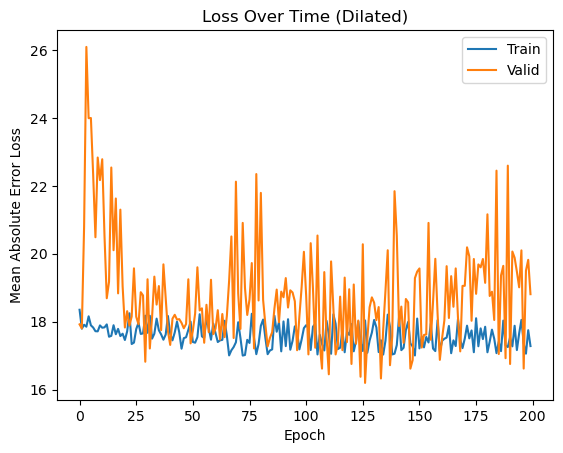

In [40]:
plt.plot(histdil.history['loss'])
plt.plot(histdil.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time (Dilated)')
plt.legend(['Train','Valid'])

626/626 [==============================] - 6s 9ms/step


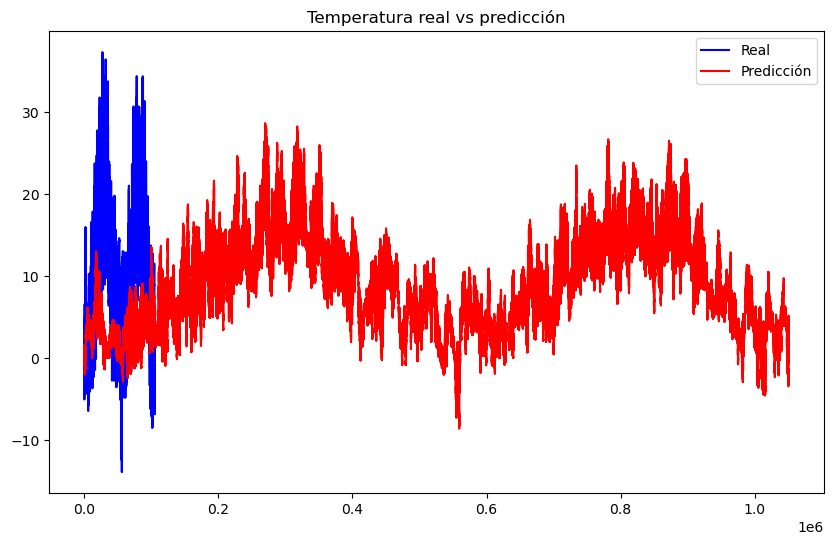

In [41]:
predictions = modeldil.predict(test_dataset)
predictions = predictions.flatten()
real_data = temperature[val+train:]
real_data = real_data[:len(predictions)]

plt.figure(figsize=(10,6))
plt.plot(real_data, color='blue', label='Real')
plt.plot(predictions, color='red', label='Predicción')
plt.title('Temperatura real vs predicción')
plt.legend()
plt.show()

626/626 [==============================] - 11s 18ms/step
[[[ 0.77627516]
  [ 1.0082048 ]
  [ 0.9631822 ]
  ...
  [ 0.88147485]
  [ 0.8634716 ]
  [ 0.84610224]]

 [[ 0.968897  ]
  [ 0.96295345]
  [ 1.0466815 ]
  ...
  [ 0.8439212 ]
  [ 0.89130425]
  [ 0.8821236 ]]

 [[ 0.9212607 ]
  [ 1.0465069 ]
  [ 0.9920198 ]
  ...
  [ 0.8763926 ]
  [ 0.92467153]
  [ 0.7758335 ]]

 ...

 [[-0.3948764 ]
  [-0.05104667]
  [-0.12112704]
  ...
  [-0.7301816 ]
  [-0.53969336]
  [-0.42962798]]

 [[-0.08669239]
  [-0.12143919]
  [ 0.6761365 ]
  ...
  [-0.56636786]
  [-0.3803496 ]
  [-0.53156364]]

 [[-0.15674397]
  [ 0.6758166 ]
  [ 0.55415   ]
  ...
  [-0.40768716]
  [-0.48190627]
  [-0.56409264]]]
[]
[]


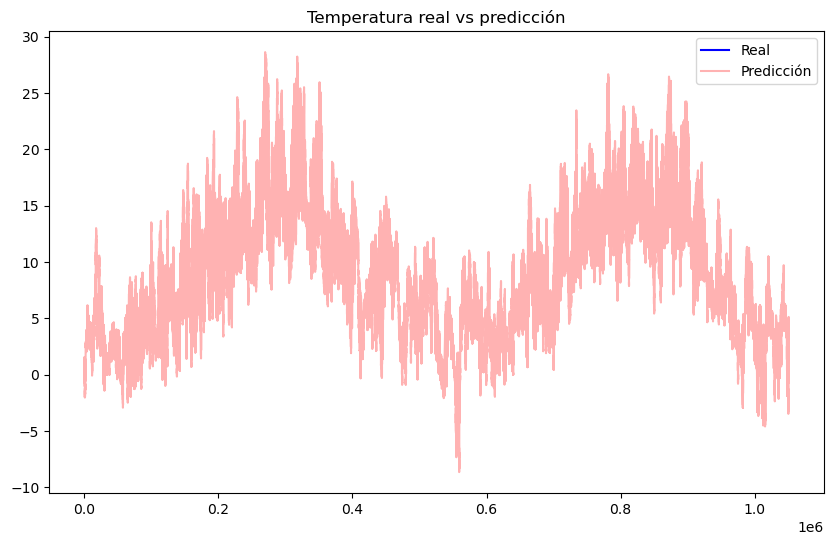

In [48]:
predictions = modeldil.predict(test_dataset)
print(predictions)
predictions = predictions.flatten()
real_data = temperature[len(temperature):]
print(real_data)
real_data = real_data[:len(predictions)]
print(real_data)
plt.figure(figsize=(10,6))
plt.plot(real_data, color='blue', label='Real')
plt.plot(predictions, color='red', label='Predicción', alpha=0.3)
plt.title('Temperatura real vs predicción')
plt.legend()
plt.show()

In [64]:
print("Esos son los datos de temperatura reales", temperature)
print(f"tenemos {len(temperature)} datos de tempratura")
print(f"tenemos {len(predictions)} datos de predicciones")
print("Las predicciones sn de este tipo saliendo del modelo", predictions.shape)
predictions = predictions.flatten()
print("las predicciones son ahora de este tipo", predictions)
print(val)
print(train) #val + train
print(test)

Esos son los datos de temperatura reales [-8.02 -8.41 -8.51 ... -3.16 -4.23 -4.82]
tenemos 420451 datos de tempratura
tenemos 1050890 datos de predicciones
Las predicciones sn de este tipo saliendo del modelo (1050890,)
las predicciones son ahora de este tipo [ 0.77627516  1.0082048   0.9631822  ... -0.40768716 -0.48190627
 -0.56409264]
105113
210225
105113


In [65]:
210225+105113

315338

In [66]:
1050890-315338

735552

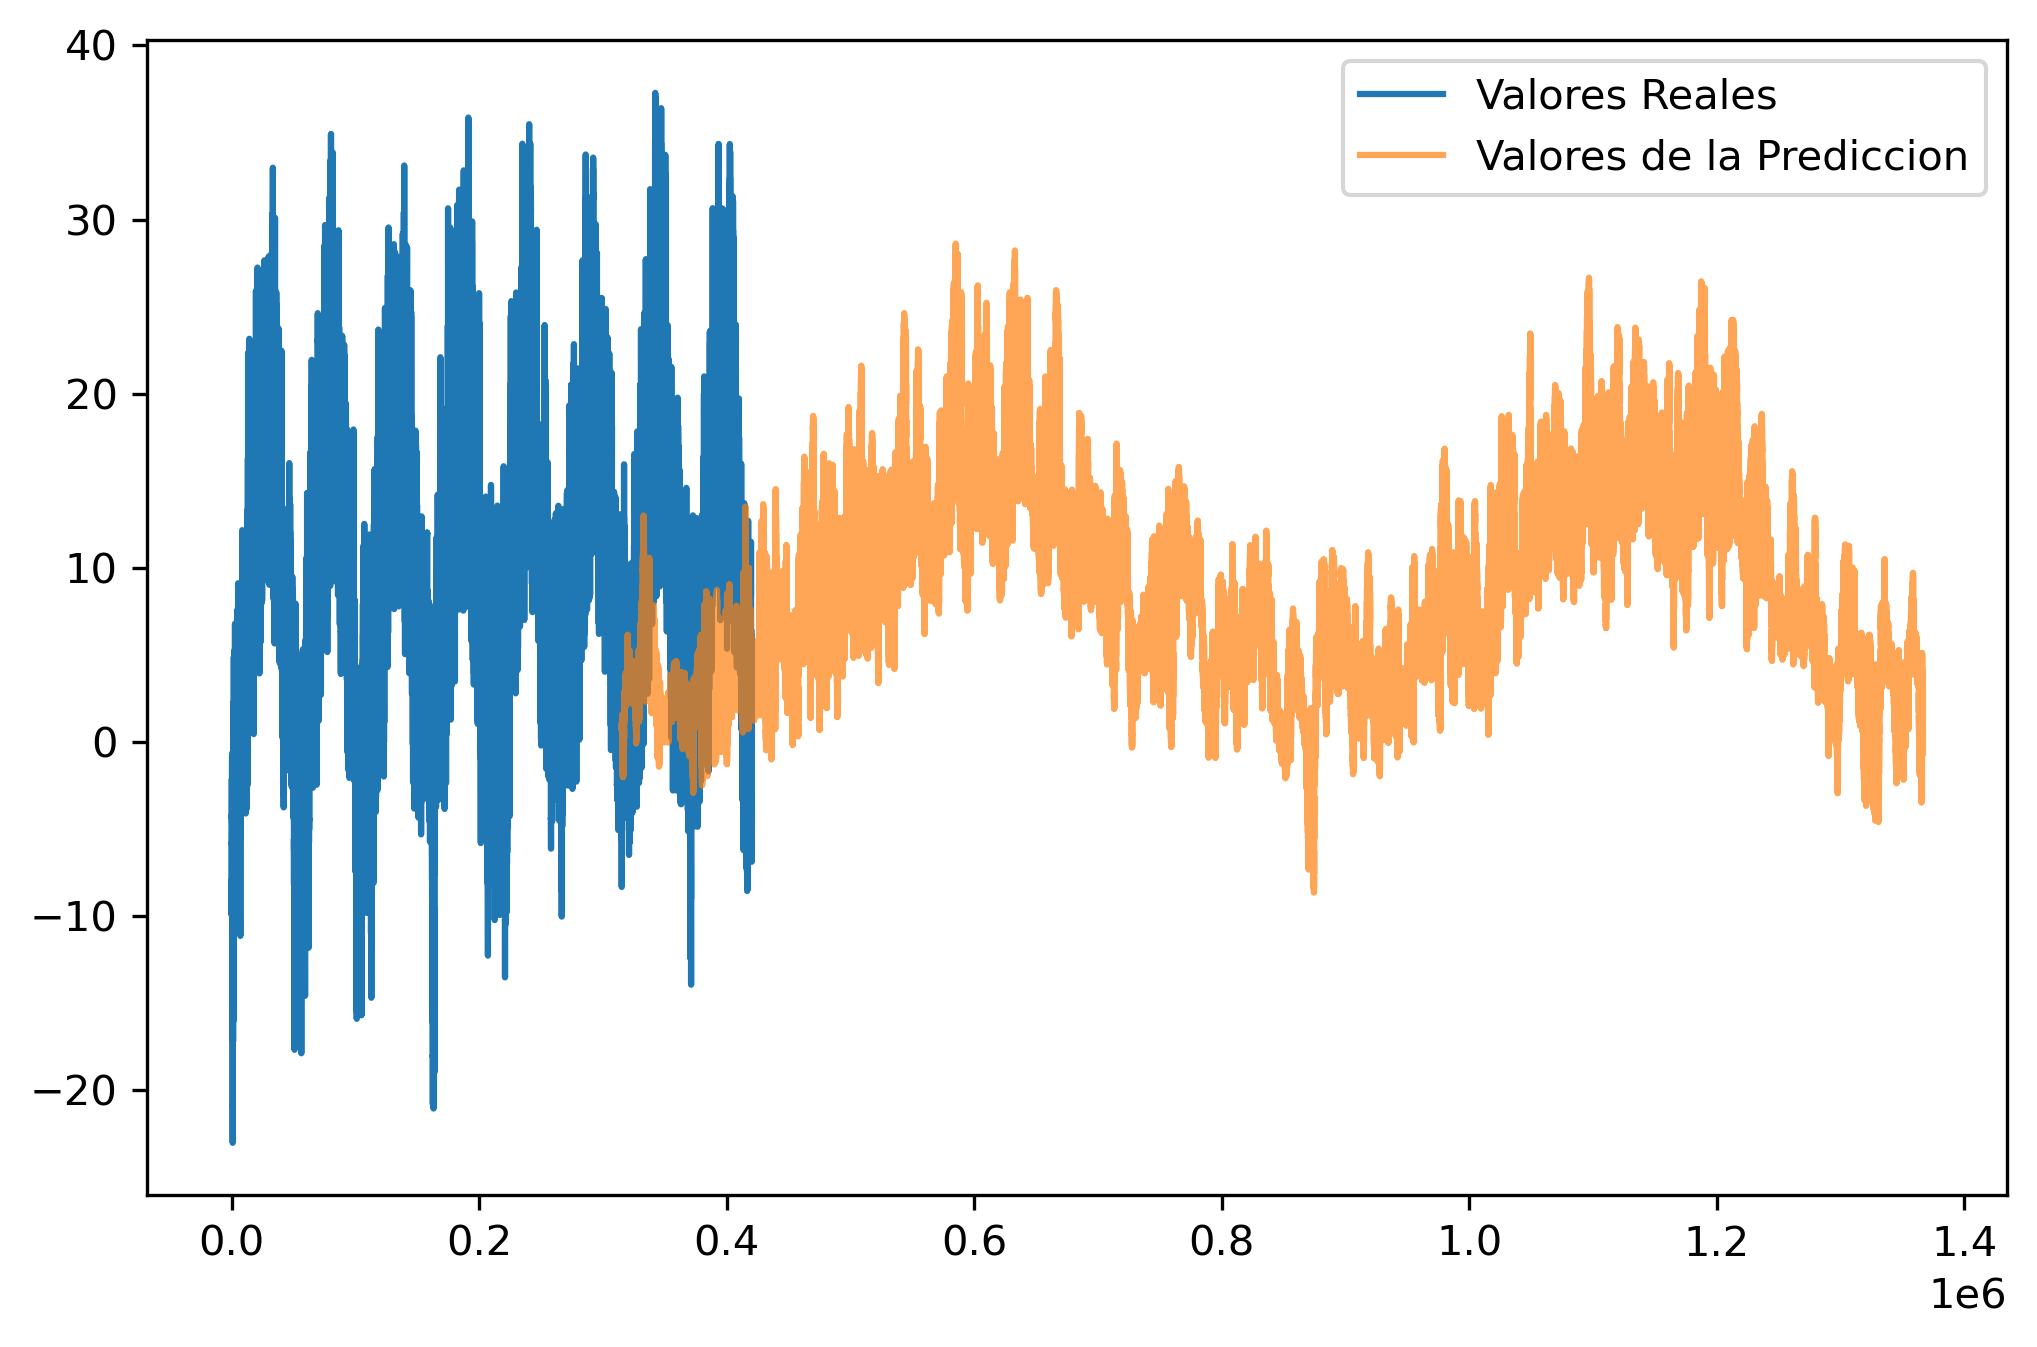

In [73]:
star_index = train + val
indices=range(star_index, star_index + len(predictions))
plt.figure(dpi=300, figsize=(8, 5))
plt.plot(range(len(temperature)), temperature, label="Valores Reales")
plt.plot(indices, predictions, label="Valores de la Prediccion", alpha=0.7)
plt.legend()